### Programa que ajusta períodos "instantáneos" usando el .polycos de una observación

*Nota*: en el archivo original se usaba la notacion científica con "D", cambiarla a "e".

Importamos los paquetes que vamos a usar

In [1]:
import matplotlib.mlab as mlab
import matplotlib as mpl
import matplotlib.pyplot as plt     # para graficar

import math
import decimal
import numpy as np
import glob                         # para hacer listas de archivo

Función que calcula la frecuencia y el período a partir de los parámetros 

In [2]:
def PERIOD(T, F0, COEFF, TMID):
    
    DT = (T - TMID) * 1440.
    
    FREQ = F0 + (1/60.) * ( COEFF[1] + 2*DT*COEFF[2] + 3*(DT**2)*COEFF[3] + 4*(DT**3)*COEFF[4] + 5*(DT**4)*COEFF[5] + 6*(DT**5)*COEFF[6] + 7*(DT**6)*COEFF[7] + 8*(DT**7)*COEFF[8] + 9*(DT**8)*COEFF[9] + 10*(DT**9)*COEFF[10] + 11*(DT**10)*COEFF[11] )
    
    return 1/FREQ

In [6]:
def PERIOD2(T, F0, COEFF, TMID):
    
    DT = (T - TMID) * 1440.
    
    FREQ = ( 11*(DT**10)*COEFF[11] + 10*(DT**9)*COEFF[10] + 9*(DT**8)*COEFF[9] + 8*(DT**7)*COEFF[8] + 7*(DT**6)*COEFF[7] + 6*(DT**5)*COEFF[6] + 5*(DT**4)*COEFF[5] + 4*(DT**3)*COEFF[4] + 3*(DT**2)*COEFF[3] + 2*DT*COEFF[2] + COEFF[1] ) * (1/60.) + F0
        
    return 1/FREQ

Abrimos el archivo .polycos y el archivo de salida

In [3]:
file = glob.glob('*.polycos')[0]      # buscamos el archivo .polycos
print(file)
lines=sum(1 for line in open(file))   # leemos el número de líneas
out = open("periods.dat", "w+")       # abrimos el archivo de salida

prepfold_timing_20200318_201231_PSR_0835-4510.pfd.polycos


Arreglos que vamos a usar

In [4]:
ncoef = np.genfromtxt ( file, comments="none", dtype=int, skip_header=1, max_rows=1, usecols=(4) ) # leemos el número de coeficientes
COEFF = np.zeros(ncoef)   # vector de coeficientes
P_array = []              # vector de períodos
T_array = []              # vector de MJD

En el archivo .polycos la información está en bloques de datos, cada uno correspondiente a un MJD distinto.
Dentro de cada bloque tenemos:
1. Una línea con el nombre de púlsar, fecha, UTC, TMID, DM.
2. Una línea con RPHASE, F0, observatorio, duración, número de coeficientes, frecuencia de observación.
3. Cuatro líneas con los coeficientes, con tres coeficientes por línea (12 en total).

In [7]:
n = 0               # número de líneas leídas del archivo .polycos
while n < lines:    # recorremos todas las líneas del archivo .polycos
    
    UTC = np.genfromtxt( file, comments="none", dtype=float, skip_header=n, max_rows=1, usecols=(2) )        # Middle point of the time span in UTC
    TMID = np.genfromtxt( file, comments="none", dtype=np.float128, skip_header=n, max_rows=1, usecols=(3) ) # Middle point of the time span in MJD
    
    F0 = np.genfromtxt( file, comments="none", dtype=float, skip_header=n+1 , max_rows=1, usecols=(1) )      # Reference spin frequency
    span_min = np.genfromtxt( file, comments="none", dtype=float, skip_header=n+1, max_rows=1, usecols=(3))  # Time span in minutes
    span_mjd = span_min * (1./(60.*24.))                                                                     # Time span in MJD
    
    T_inicial = TMID - span_mjd/2.                                                                           # Starting point of the time span in MJD
    
    matrix = np.genfromtxt(file, usecols=range(3), dtype=np.float128, skip_header=n+2, max_rows=4)           # Matriz de coeficientes
    COEFF = matrix.flatten('C')                                                                              # Vector de coeficientes
    
    out.write("UTC_mid = " + str(UTC) + "\n")
    out.write("T[MJD]    P[ms]    delta_T[min]")
    
    delta_T = 0.
    T = T_inicial
    while delta_T < span_mjd:                # recorremos el timespan de cada bloque de datos
        
        P_seg = PERIOD2(T, F0, COEFF, TMID)   # período en segundos
        P_ms  = P_seg * 1000.                # período en milisegundos
        P_mjd = P_seg * (1./(60.*60.*24.))   # período en MJD
        P_array.append(P_ms)
        T_array.append(T)
        
        out.write(str(T) + " " + str(P_ms) + " " + str(delta_T * 60. * 24.))
#        print((str(T) + " " + str(P_ms) + " " + str(delta_T * 60. * 24.)))
    
        T += P_mjd                           # al punto T en que estábamos parades le sumamos el período P
        
        delta_T = T - T_inicial              # calculamos el apartamiento respecto al T_inicial del bloque
    
    n += 6                                   # después de completar el span del bloque, habremos avanzado 6 líneas en el .polycos
    
out.close()

with open('periods.npy', 'wb') as outnp:     # guardamos el vector de períodos en un archivo .npy
    np.save(outnp, P_array)


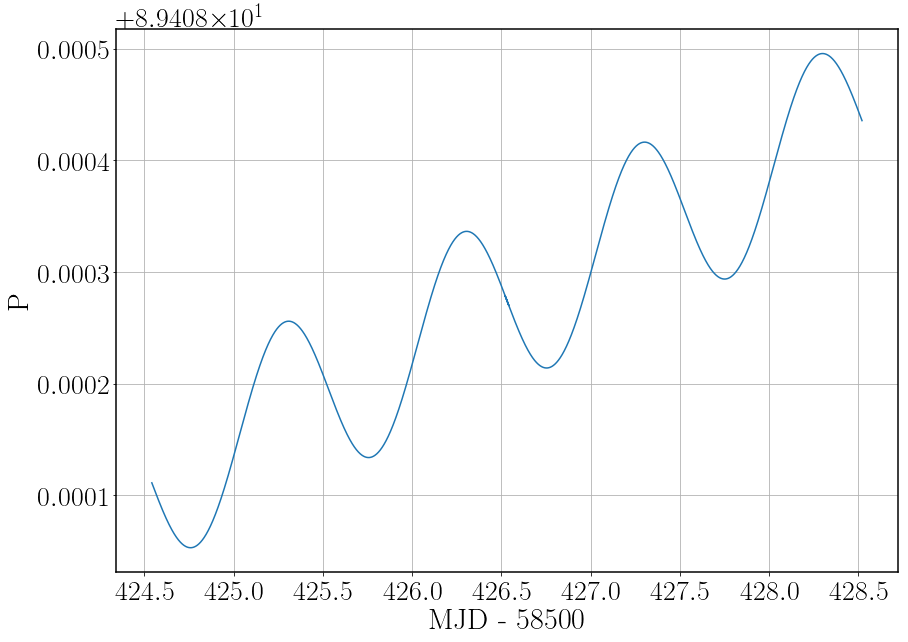

In [8]:
plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)

norm = np.full(len(T_array), 58500.)

plt.figure(figsize=(14,10))
plt.grid()
#plt.xlim(T_array[0], T_array[0] + 1./24. * 3.) 

plt.xlabel('MJD - 58500')
plt.ylabel('P [ms]')

#plt.axhline(y=89.4083119942048, color='r', linestyle='-')
plt.plot(T_array - norm, P_array)
#plt.savefig(file + '.png', bbox_inches='tight')
plt.show()